<a href="https://colab.research.google.com/github/tphanir/NeuralStyleFusion/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms, models

**FUNCTION TO CONVERT AN IMAGE TO A TENSOR**

In [ ]:
def imageToTensor(image):
  size = 400
  image = Image.open(image)

  im_size = size

  in_transform = transforms.Compose([
      transforms.Resize((im_size, im_size)),
      transforms.ToTensor(),
  ])

  image = in_transform(image).unsqueeze(0)

  return image


**FUNCTION TO CONVERT A TENSOR TO AN IMAGE**

In [ ]:
def tensorToImage(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.squeeze()
  image = torch.permute(image,(1, 2, 0))
  image = image.numpy()
  image = image.clip(0,1)

  return image

**FUNCTION TO EXTRACT FEATURES**

In [ ]:
def get_features(image, model):
  layers = {
        '0' : 'conv1_1',
        '5' : 'conv2_1',
        '10' : 'conv3_1',
        '19' : 'conv4_1',
        '21' : 'conv4_2', ## content layer
        '28' : 'conv5_1'
    }

  features = {}
  x = image
  for name, layer in enumerate(model):
    x = layer(x)
    if str(name) in layers:
      features[layers[str(name)]] = x

  return features

**FUNCTION FOR GRAM MATRIX**

In [ ]:
def gram_matrix(tensor):
  _, n_c, n_h, n_w = tensor.size()
  tensor = tensor.view(n_c, n_h * n_w)
  g = torch.mm(tensor, tensor.t())
  return g

**SETTING UP THE MODEL**

In [ ]:
vgg = models.vgg19(pretrained=True).features.to("cuda:0")
for params in vgg.parameters():
  params.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 119MB/s]


**LOADING THE IMAGES AND FEATURES**

In [ ]:
content = imageToTensor("content.jpg").to("cuda:0")
style = imageToTensor("style14.jpg").to("cuda:0")

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

**COMPUTING GRAM MATRIX FOR STYLE IMAGE FOR ALL STYLE LAYERS**

In [ ]:
all_gm = {}

for layer in style_features:
  all_gm[layer] = gram_matrix(style_features[layer])

**GENERATING A RANDOM IMAGE**

In [ ]:
G1 = torch.rand((1,3,400,400)).to("cuda:0")
G = G1.clone().requires_grad_(True).to("cuda:0")
G.is_leaf

True

**STYLE WEIGHTS**

In [ ]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [ ]:
alpha = 1000000000000
beta = 40

**ADAM OPTIMIZER**

In [ ]:
optimizer = torch.optim.Adam([G], lr=0.02)
loss = torch.nn.MSELoss()

**TRAINING LOOP**

39282221056.0


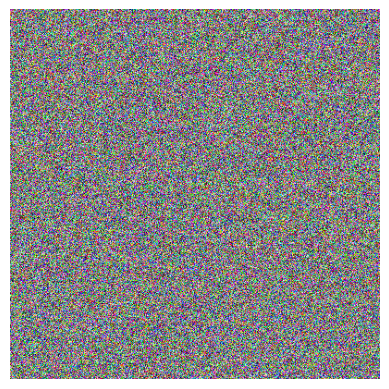

39282221056.0


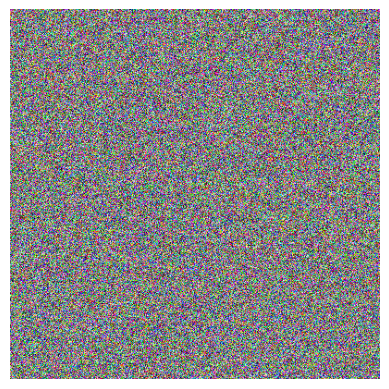

39282221056.0


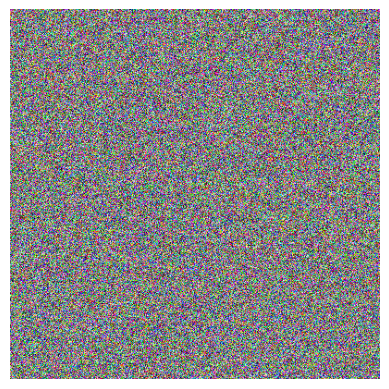

39282221056.0


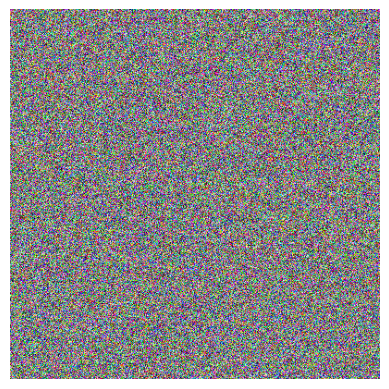

KeyboardInterrupt: ignored

In [ ]:
for ii in range(4000):
  target_features = get_features(G,vgg)
  _, n_c, n_w, n_h = target_features['conv4_2'].shape

  content_loss = loss(target_features['conv4_2'], content_features['conv4_2'])

  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = all_gm[layer]

    layer_style_loss = style_weights[layer] * loss(target_gram[layer], style_gram[layer])
    style_loss += layer_style_loss

  total_loss =  alpha * content_loss + beta * style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii%200==0:
    print(total_loss.item())
    plt.imshow(tensorToImage(G))
    plt.axis("off")
    plt.show()


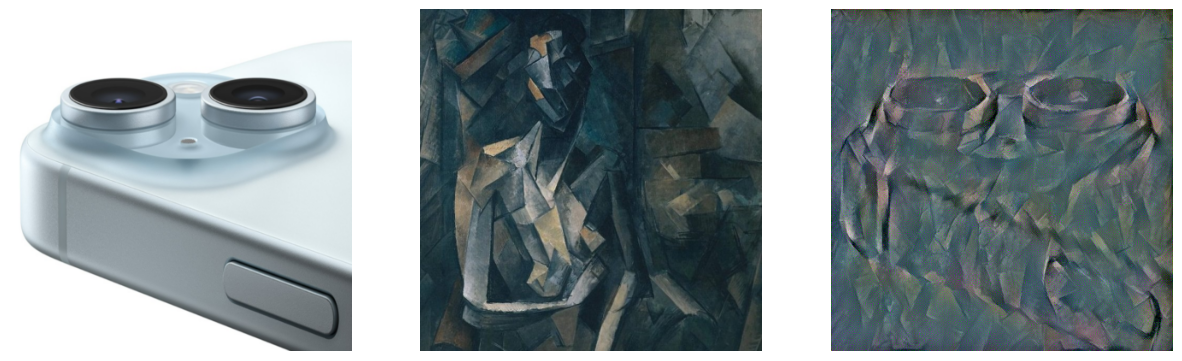

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax1.imshow(tensorToImage(content))
ax2.imshow(tensorToImage(style))
ax3.imshow(tensorToImage(G))